# Get Elevation and Perform QAQC

### Import Statements

In [63]:
import requests
import os
import zipfile
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import arcpy

### Download Elevation Data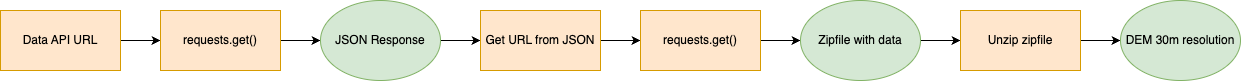

Credits: chat.openai.com

In [40]:
#Assign the Paths
elev_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(elev_path)
elev_db = elev_path + '\\Commons_Data\\elev_30m_digital_elevation_model.gdb'
arcpy.env.workspace = elev_db

#Request information from the API 
response = requests.get("https://gisdata.mn.gov/api/3/action/package_show?id=elev-30m-digital-elevation-model")

#Get response code 
if response.status_code == 200:
    #parse the JSON data from the response
    json = response.json()
    #Get url from API
    geo_url = json['result']['resources'][1]['url']
else:
    print("Failed to fetch.")

#Get the directory
direct = os.getcwd()
#Path to get zipfile
geo_name = os.path.join(direct, "elev_data.zip")
#Getting URL and response is used for download
geo_result = requests.get(geo_url, stream=True)

#Define where the data should go
geo_folder = os.path.join(direct, "Commons_Data")
if not os.path.exists(geo_folder):
    os.mkdir(geo_folder)

#Save the downloaded ZIP file and extract its contents
with open(geo_name, 'wb') as file:
    shutil.copyfileobj(geo_result.raw, file)
#Open and Extract Zip
with zipfile.ZipFile(geo_name, 'r') as geo_zip:
    geo_zip.extractall(geo_folder)

### Download Minnesota Boundary

### 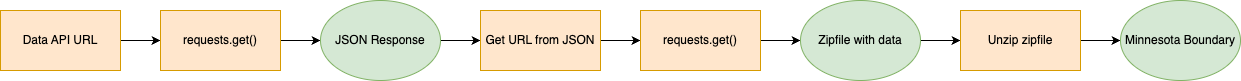

In [41]:
#Get zipfile
direct = os.getcwd()
geo_name = os.path.join(direct, "geo_data.zip")

#Request data from API. 
response = requests.get("https://gisdata.mn.gov/api/3/action/package_show?id=bdry-state-of-minnesota")

#Confirm request was successful.
if response.status_code == 200:
    json = response.json()   
    #Get url from JSON.
    geo_url = json['result']['resources'][1]['url']
else:
    print(f"Failed.")
    
#URL from JSON
geo_result = requests.get(geo_url, stream=True)
#New folder path
folder_new = os.path.join(direct, "Commons_Data")
#Create folder
if not os.path.exists(folder_new):
    os.mkdir(folder_new)
#Extract zip into folder
with open(geo_name, 'wb') as file:
    shutil.copyfileobj(geo_result.raw, file)
with zipfile.ZipFile(geo_name, 'r') as zip_Mn_Geo:
    zip_Mn_Geo.extractall(folder_new)

### QAQC

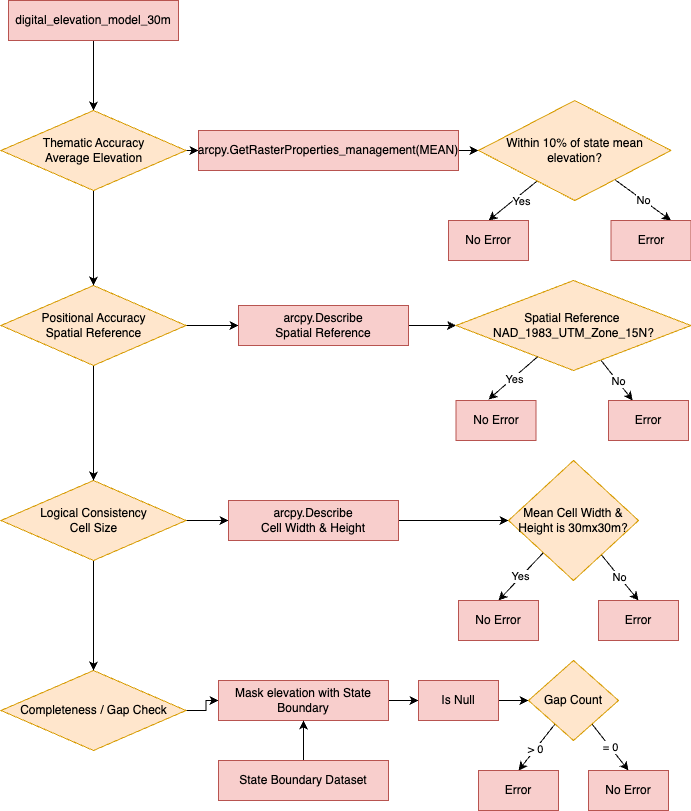

In [57]:
#Thematic Accuracy, Positional Accuracy and Logical Consistency
elev_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(elev_path)
elev_db = elev_path + '\\Commons_Data\\elev_30m_digital_elevation_model.gdb'
arcpy.env.workspace = elev_db
raster = "digital_elevation_model_30m"

#Describe the raster and get srs and cell size
describe = arcpy.Describe(raster)
srs = describe.spatialReference
cell_width = describe.meanCellWidth
cell_height = describe.meanCellHeight

#Create raster from dataset
raster = arcpy.Raster(raster)

#Average Elevation
avg_elev_result = arcpy.GetRasterProperties_management(raster, 'MEAN')
avg_elev = float(avg_elev_result.getOutput(0))

#Give or take 10% of statewide mean elevation
low_elev = 1080
high_elev = 1320

#Print the results
#Check is average elevation is acceptable
if low_elev <= avg_elev <= high_elev:
    print(f"Thematic Accuracy: Average Elevation ({avg_elev}) is within acceptable range.")
else:
    print(f"Thematic Accuracy: Average Elevation ({avg_elev}) outside of acceptable range.")
#Check if the spatial reference name is "NAD_1983_UTM_Zone_15N"
if srs.name == "NAD_1983_UTM_Zone_15N":
    print("Positional Accuracy: No Error. Matches SRS: {}".format(srs.name))
else:
    print("Positional Accuracy: Error. Data does not match SRS.")
#Check if the cell size is 30 by 30 meters
if cell_width == 30 and cell_height == 30:
    print("Logical Consistency: Cell size of width: {}m and height: {}m is acceptable.".format(cell_width, cell_height))
else:
    print("Logical Consistency: Cell size of width: {}m and height: {}m is not acceptable.".format(cell_width, cell_height))

Thematic Accuracy: Average Elevation (1217.65105684861) is within acceptable range.
Positional Accuracy: No Error. Matches SRS: NAD_1983_UTM_Zone_15N
Logical Consistency: Cell size of width: 30.0m and height: 30.0m is acceptable.


In [43]:
#Completness Check
boundary_path = r"../../Commons_Data/bdry_state_of_minnesota.gdb/state_of_minnesota"
#Path to Elevation Raster
raster_path = "digital_elevation_model_30m"
#Convert Boundary to Raster
raster_mask = "minnesota_mask"

arcpy.conversion.PolygonToRaster(
    in_features=boundary_path,
    value_field="OBJECTID",
    out_rasterdataset=raster_mask,
    cell_assignment="MAXIMUM_AREA",
    priority_field="NONE",
    cellsize=raster_path,
    build_rat="BUILD"
)

#Set NoData for areas not within the boundary
mask_raster_nodata = arcpy.ia.SetNull(raster_mask, 1, "VALUE <> 1")
#Apply mask to dataset
raster_mask = "raster_mask"
arcpy.env.mask = mask_raster_nodata
#Create new raster with mask
arcpy.CopyRaster_management(raster_path, raster_mask)

#Assign variable for raster with mask
elev_raster = raster_mask
#Look for gaps in data
gaps = arcpy.sa.IsNull(elev_raster)
#Count the number of gaps
gaps = arcpy.GetCount_management(gaps)
#Output result from check
if int(gaps.getOutput(0)) > 0:
    print(f"Completeness: Elevation contains {gaps.getOutput(0)} gaps.")
else:
    print("Completness: Elevation data contains no gaps.")

Completeness: Elevation contains 2 gaps.
